In [1]:
import os
from os.path import realpath, join
import sys
sys.path.insert(0, '/home/chuah/mitsuba3-camera/build/python')

import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

mi.set_variant('cuda_ad_dispersion')

In [2]:
SCENE_DIR = realpath('../tutorials/scenes')

# Make sure that resources from the scene directory can be found
mi.Thread.thread().file_resolver().append(SCENE_DIR)

config = {
        'emitter': 'gray',
        'lens_subdiv_level': 5,
        'render_resolution': (128, 128),
        'spp': 64,
        'max_iterations': 5000,
        # 'learning_rate': 3e-3,
        'learning_rate': 3e-4,
    }

output_dir = realpath(join('.', 'outputs', 'lens'))
os.makedirs(output_dir, exist_ok=True)
print('[i] Results will be saved to:', output_dir)

[i] Results will be saved to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens


# Set lens parameters

In [3]:
from scripts.lens_design.lens import ConicSurface, LensMaterial, LensSystem

surf0 = { 'c': -1/2.4, 'K': 0.0, 'z0': 4.7 }
surf1 = { 'c': 1/2.4, 'K': 0.0, 'z0': 5.0 }
surf2 = { 'c': 1/14, 'K': 0.0, 'z0': 5.1 }

# 1000 itrs:
# 'c': -0.2983226180076599
# 'c':  0.6604698300361633
# 'c':  0.2334931194782257

# 5000 itrs:
# 'c': -0.17739839851856232
# 'c': 0.6790199279785156
# 'c': 0.3298546373844147

surf0 = ConicSurface(**surf0)
surf1 = ConicSurface(**surf1)
surf2 = ConicSurface(**surf2)
# surfaces = [surf0, surf1]
# materials = [LensMaterial("nbk7", 1.5047, 64.17)]

surfaces = [surf0, surf1, surf2]
materials = [LensMaterial("nbk7", 1.5047, 64.17), LensMaterial("sf2", 1.64769, 33.85)]


# materials = [LensMaterial("nbk7", 1.5047, 64.17), LensMaterial("sf2", 1.64769, 33.85)]
# surfaces = [surf0, surf1, surf1a, surf2]
# materials = [LensMaterial("nbk7", 1.5047, 64.17), LensMaterial(), LensMaterial()]
radial_extents = [0.8 for _ in surfaces]

lens_system = LensSystem(surfaces, radial_extents, materials)
lens_system.initialize_geometry(output_dir)
# lens_system.meshplot_geometry()

LensMaterial[
	name=air,
	ior=1.000277,
	Vd=0.0,
]
LensMaterial[
	name=nbk7,
	ior=1.5047,
	Vd=64.17,
]
LensMaterial[
	name=sf2,
	ior=1.64769,
	Vd=33.85,
]
V_ lies on sphere: True
[+] Wrote lens mesh (subdivs=5) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens0.ply
[+] Wrote baffle mesh file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/baffle0.ply
V_ lies on sphere: True
[+] Wrote lens mesh (subdivs=5) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens1.ply
[+] Wrote baffle mesh file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/baffle1.ply
V_ lies on sphere: True
[+] Wrote lens mesh (subdivs=5) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens2.ply
[+] Wrote baffle mesh file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/baffle2.ply


# Emitter creation

In [4]:
emitter = {
    'type':'directionalarea',
    'radiance': {
        'type': 'spectrum',
        'value': 0.05
    },
}

# emitter = {
#     'type':'constant',
#     'radiance': {
#         'type': 'spectrum',
#         'value': 0.05
#     },
# }



# Create the integrator

In [5]:
integrator = {
    'type': 'ptracer',
    'samples_per_pass': 256,    # TODO: prb?
    'max_depth': lens_system.size() + 2,
}
# integrator = {
#     'type': 'ptracer',
#     'samples_per_pass': 256,    # TODO: prb?
#     'max_depth': 4,
#     'hide_emitters': False,
# }

# Assemble the scene

In [6]:
# Looking at the receiving plane, not looking through the lens
# TODO: set axial positions appropriately
# - film plane (OK)
# - emitter (arbitrary, set to max{z0})
# - camera (OK, but might need to be adjusted per-problem)

z_sensor = lens_system.rear_z - 0.1
sensor_to_world = mi.ScalarTransform4f.look_at(
    target=[0, 0, -20],
    origin=[0, 0, 0.2],
    up=[0, 1, 0]
)

resx, resy = config['render_resolution']
sensor = {
    'type': 'perspective',
    'near_clip': 0.05,
    'far_clip': 20,
    'fov': 45,
    'to_world': sensor_to_world,

    'sampler': {
        'type': 'independent',
        'sample_count': 512  # Not really used
    },
    'film': {
        'type': 'hdrfilm',
        'width': resx,
        'height': resy,
        'pixel_format': 'rgb',

        # "crop_width": 3,
        # "crop_height": 3,
        # "crop_offset_x": 61,
        # "crop_offset_y": 61,

        'rfilter': {
            # Important: smooth reconstruction filter with a footprint larger than 1 pixel.
            'type': 'gaussian'
        }
    },
}

Define the full scene

In [7]:
scene = {
    'type': 'scene',
    'sensor': sensor,
    'integrator': integrator,
    # # Glass BSDF
    # 'simple-glass': {                   # TODO: dispersive model
    #     'type': 'dielectric',
    #     'id': 'simple-glass-bsdf',
    #     'ext_ior': 'air',
    #     'int_ior': 1.5,
    #     'specular_reflectance': { 'type': 'spectrum', 'value': 0 },
    # },
    'white-bsdf': {
        'type': 'diffuse',
        'id': 'white-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (1, 1, 1) },
    },
    'black-bsdf': {
        'type': 'diffuse',
        'id': 'black-bsdf',
        'reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    # Receiving plane
    'receiving_plane': {
        'type': 'obj',
        'id': 'receiving_plane',
        'filename': 'meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f.look_at(
                target=[0, 0, 1],
                origin=[0, 0, 0],
                up=[0, 1, 0]
                # target=[0, 0, 1],
                # origin=[0, 0, -7],
                # up=[0, 1, 0]
            ).scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'white-bsdf'},
    },
    # Ray source: directional area emitter
    # TODO: choose correct size: scales with aperture
    # TODO: choose correct direction: diff angles for different fields
    'focused-emitter-shape': {
        'type': 'obj',
        'filename': 'meshes/circle.obj',
        'to_world': mi.ScalarTransform4f.look_at(
            target=[0, 0, 0],
            origin=[0, 0, 10],
            up=[0, 1, 0]
            # target=[0, 0, 0],
            # origin=[0, 0, 5],
            # up=[0, 1, 0]
        ),
        'bsdf': {'type': 'ref', 'id': 'black-bsdf'},
        'focused-emitter': emitter,
    },
}

lens_system.add_to_scene(scene)

scene = mi.load_dict(scene)

# for element in lens_system:
#     element.finalize_scene(scene)

{'type': 'ply', 'id': 'lens0', 'filename': '/home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens0.ply', 'bsdf': {'type': 'dispersive', 'id': 'bsdf0_air-to-nbk7', 'ext_ior': 1.000277, 'ext_V_d': 0.0, 'int_ior': 1.5047, 'int_V_d': 64.17, 'specular_reflectance': {'type': 'spectrum', 'value': 0}}}
{'type': 'ply', 'id': 'lens1', 'filename': '/home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens1.ply', 'bsdf': {'type': 'dispersive', 'id': 'bsdf1_nbk7-to-sf2', 'ext_ior': 1.5047, 'ext_V_d': 64.17, 'int_ior': 1.64769, 'int_V_d': 33.85, 'specular_reflectance': {'type': 'spectrum', 'value': 0}}}
{'type': 'ply', 'id': 'lens2', 'filename': '/home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens2.ply', 'bsdf': {'type': 'dispersive', 'id': 'bsdf2_sf2-to-air', 'ext_ior': 1.64769, 'ext_V_d': 33.85, 'int_ior': 1.000277, 'int_V_d': 0.0, 'specular_reflectance': {'type': 'spectrum', 'value': 0}}}


In [8]:
# TODO: no dispersive bsdf string?
scene

Scene[
  children = [
    PLYMesh[
      name = "baffle0.ply",
      bbox = BoundingBox3f[
        min = [-5, -5, 4.83726],
        max = [5, 5, 4.83726]
      ],
      vertex_count = 320,
      vertices = [7.5 KiB of vertex data],
      face_count = 640,
      faces = [7.5 KiB of face data],
      face_normals = 0
    ],
    PLYMesh[
      name = "baffle1.ply",
      bbox = BoundingBox3f[
        min = [-5, -5, 4.86274],
        max = [5, 5, 4.86274]
      ],
      vertex_count = 320,
      vertices = [7.5 KiB of vertex data],
      face_count = 640,
      faces = [7.5 KiB of face data],
      face_normals = 0
    ],
    PLYMesh[
      name = "baffle2.ply",
      bbox = BoundingBox3f[
        min = [-5, -5, 5.07712],
        max = [5, 5, 5.07712]
      ],
      vertex_count = 320,
      vertices = [7.5 KiB of vertex data],
      face_count = 640,
      faces = [7.5 KiB of face data],
      face_normals = 0
    ],
    SmoothDiffuse[
      reflectance = UniformSpectrum[value=[0]]
    ],

2024-05-02 14:01:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


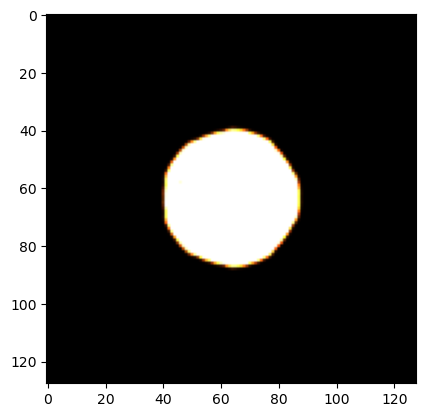

In [9]:
image_init = mi.render(scene, spp=512*4)
plt.imshow(image_init)

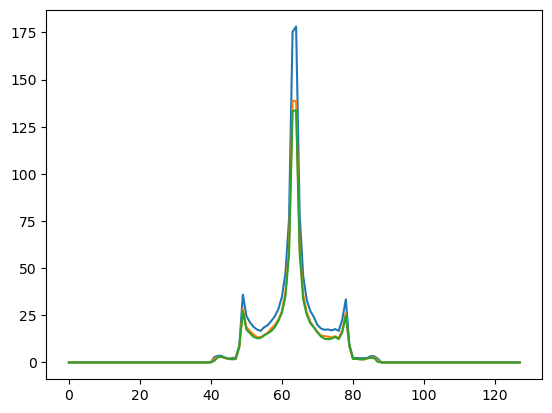

In [10]:
spot_init = image_init.numpy()[config['render_resolution'][0] // 2]
plt.plot(spot_init)

# Apply the shape parameters

In [11]:
# params_scene = mi.traverse(scene)

# # We will always apply displacements along the original normals and
# # starting from the original positions.
# positions_initial = dr.unravel(mi.Vector3f, params_scene['lens.vertex_positions'])
# normals_initial   = dr.unravel(mi.Vector3f, params_scene['lens.vertex_normals'])

# lens_si = dr.zeros(mi.SurfaceInteraction3f, dr.width(positions_initial))
# lens_si.uv = dr.unravel(type(lens_si.uv), params_scene['lens.vertex_texcoords'])

# def apply_displacement(amplitude = 1.):
#     # Enforce reasonable range. For reference, the receiving plane
#     # is 7 scene units away from the lens.
#     vmax = 1 / 100.
#     params['data'] = dr.clamp(params['data'], -vmax, vmax)
#     dr.enable_grad(params['data'])

#     height_values = heightmap_texture.eval_1(lens_si)
#     new_positions = (height_values * normals_initial * amplitude + positions_initial)
#     params_scene['lens.vertex_positions'] = dr.ravel(new_positions)
#     params_scene.update()

params_scene = mi.traverse(scene)
opt = mi.ad.Adam(lr=config['learning_rate'])

lens_system.save_init_state(params_scene)
lens_system.add_to_optimizer(opt)

In [12]:
params_scene

SceneParameters[
  -------------------------------------------------------------------------------------------------------
  Name                                                Flags    Type           Parent
  -------------------------------------------------------------------------------------------------------
  baffle0.bsdf.reflectance.value                      ∂        Float          UniformSpectrum
  baffle0.silhouette_sampling_weight                           float          PLYMesh
  baffle0.faces                                                UInt           PLYMesh
  baffle0.vertex_positions                            ∂, D     Float          PLYMesh
  baffle0.vertex_normals                              ∂, D     Float          PLYMesh
  baffle0.vertex_texcoords                            ∂        Float          PLYMesh
  baffle1.silhouette_sampling_weight                           float          PLYMesh
  baffle1.faces                                                UInt         

In [13]:
opt

Adam[
  variables = ['lens0_c', 'lens1_c', 'lens2_c'],
  lr = {'default': 0.0003},
  betas = (0.9, 0.999),
  eps = 1e-08
]

In [14]:
from scripts.lens_design.geometry import meshplot_gizmo
from gpytoolbox import cone
import numpy as np
import meshplot as mp

def draw_camera(sensor_to_world):
    # plot sensor as a +z-facing cone
    V, F = cone(16,2)
    V += np.array([[0,0,-1]])
    V *= -1

    # apply camera-to-world transform
    V = (sensor_to_world @ mi.Point3f(V)).numpy()
    p_ = mp.plot(V,F)
    meshplot_gizmo(p_)
    return p_

def meshplot_scene(params):
    p_ = draw_camera(params['sensor.to_world'])
    meshes = ['focused-emitter-shape', 'receiving_plane']
    lens_system.meshplot_geometry(p_)
    for mesh in meshes:
        V = dr.unravel(mi.Point3f, params[f'{mesh}.vertex_positions']).numpy()
        F = dr.unravel(mi.Point3u, params[f'{mesh}.faces']).numpy()
        p_.add_mesh(V, F, shading={"wireframe": True})
    return p_

meshplot_scene(params_scene)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

# Optimization

In [15]:
# TODO: further validation of this loss
def rms_loss(image):
    scaled_image = image / dr.mean(dr.detach(image))
    i = dr.arange(mi.Float, image.shape[0])
    j = dr.arange(mi.Float, image.shape[1])
    ii, jj = dr.meshgrid(i, j, indexing='ij')
    # I = scaled_image[:,:,0]     # TODO: use grayscale version of the image
    I = (scaled_image[:,:,0] + scaled_image[:,:,1] + scaled_image[:,:,2]) / 3.0
    ibar = dr.sum(ii * I) / dr.sum(I)
    jbar = dr.sum(jj * I) / dr.sum(I)
    rms = dr.sum(I * (dr.sqr(ii - ibar) + dr.sqr(jj - jbar))) * dr.rcp(dr.sum(I))
    # rms = dr.sum(I * (dr.sqr(ii - image.shape[0] / 2) + dr.sqr(jj - image.shape[1] / 2))) * dr.rcp(dr.sum(I))
    return rms

In [16]:
print(rms_loss(image_init))
print(opt.variables)


[149.15225219726562]
{'lens0_c': [-0.4166666567325592], 'lens1_c': [0.4166666567325592], 'lens2_c': [0.0714285746216774]}


In [17]:
params_scene#['baffle0.bsdf.reflectance.value']

SceneParameters[
  -------------------------------------------------------------------------------------------------------
  Name                                                Flags    Type           Parent
  -------------------------------------------------------------------------------------------------------
  baffle0.bsdf.reflectance.value                      ∂        Float          UniformSpectrum
  baffle0.silhouette_sampling_weight                           float          PLYMesh
  baffle0.faces                                                UInt           PLYMesh
  baffle0.vertex_positions                            ∂, D     Float          PLYMesh
  baffle0.vertex_normals                              ∂, D     Float          PLYMesh
  baffle0.vertex_texcoords                            ∂        Float          PLYMesh
  baffle1.silhouette_sampling_weight                           float          PLYMesh
  baffle1.faces                                                UInt         

In [18]:
lens_system.update(params_scene, opt)

# Perform a differentiable rendering of the scene
image = mi.render(scene, params_scene, spp=2*512, spp_grad=512)

# Scale-independent L2 function
loss = rms_loss(image)
dr.backward(loss)

print(opt.variables)
opt.step()

print(opt.variables)

2024-05-02 14:01:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:01:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

{'lens0_c': [-0.4166666567325592], 'lens1_c': [0.4166666567325592], 'lens2_c': [0.0714285746216774]}
{'lens0_c': [-0.41636666655540466], 'lens1_c': [0.41696664690971375], 'lens2_c': [0.07112857699394226]}


In [19]:
import time
start_time = time.time()
mi.set_log_level(mi.LogLevel.Warn)
iterations = config['max_iterations']
loss_values = []
spp = config['spp']

for it in range(iterations):
    t0 = time.time()

    # Apply displacement and update the scene BHV accordingly
    lens_system.update(params_scene, opt)

    # Perform a differentiable rendering of the scene
    image = mi.render(scene, params_scene, seed=it, spp=2 * spp, spp_grad=spp)

    # Scale-independent L2 function
    loss = rms_loss(image)

    # Back-propagate errors to input parameters and take an optimizer step
    dr.backward(loss)

    # Take a gradient step
    opt.step()

    # Carry over the update to our "latent variable" (the heightmap values)
    # TODO: does this do anything?
    params_scene.update(opt)

    # Log progress
    elapsed_ms = 1000. * (time.time() - t0)
    current_loss = loss[0]
    loss_values.append(current_loss)
    mi.Thread.thread().logger().log_progress(
        it / (iterations-1),
        f'Iteration {it:03d}: loss={current_loss:g} (took {elapsed_ms:.0f}ms)',
        'Caustic Optimization', '')

    # Increase rendering quality toward the end of the optimization
    if it in (int(0.7 * iterations), int(0.9 * iterations)):
        spp *= 2
        opt.set_learning_rate(0.5 * opt.lr['c'])
        opt.set_learning_rate(0.5 * opt.lr['K'])


end_time = time.time()
print(((end_time - start_time) * 1000) / iterations, ' ms per iteration on average')
mi.set_log_level(mi.LogLevel.Info)

2024-05-02 14:05:31 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:34 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:35 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:35 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:35 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:35 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:35 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:35 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:35 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:35 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:35 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:35 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:35 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:35 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:35 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:36 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:36 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:36 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:36 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:36 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:36 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:36 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:36 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:36 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:36 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:36 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:36 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:37 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:37 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:37 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:37 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:37 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:37 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:37 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:37 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:37 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:37 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:37 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:37 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:37 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:38 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:38 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:38 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:38 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:38 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:38 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:38 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:38 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:38 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:38 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:38 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:38 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:39 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:39 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:39 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:39 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:39 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:39 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:39 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:39 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:39 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:39 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:39 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:39 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:39 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:40 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:40 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:40 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:40 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:40 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:40 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:40 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:40 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:40 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:40 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:40 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:40 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:40 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:41 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:41 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:41 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:41 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:41 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:41 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:41 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:41 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:41 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:41 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:41 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:41 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:42 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:42 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:42 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:42 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:42 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:42 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:42 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:42 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:42 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:42 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:42 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:42 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:42 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:43 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:43 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:43 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:43 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:43 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:43 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:43 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:43 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:43 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:43 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:43 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:43 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:43 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:44 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:44 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:44 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:44 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:44 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:44 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:44 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:44 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:44 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:44 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:44 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:44 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:45 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:46 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:46 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:46 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:46 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:46 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:46 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:46 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:46 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:46 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:46 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:46 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:46 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:46 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:47 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:48 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:48 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:48 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:48 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:48 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:48 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:48 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:48 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:48 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:48 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:48 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:48 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:48 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:49 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:49 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:49 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:49 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:49 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:49 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:49 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:49 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:49 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:49 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:49 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:49 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:49 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:50 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:50 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:50 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:50 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:50 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:50 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:50 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:50 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:50 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:50 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:50 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:50 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:51 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:51 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:51 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:51 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:51 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:51 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:51 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:51 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:51 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:51 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:51 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:51 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:51 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:52 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:52 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:52 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:52 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:52 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:52 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:52 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:52 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:52 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:52 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:52 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:52 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:52 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:53 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:53 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:53 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:53 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:53 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:53 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:53 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:53 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:53 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:53 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:53 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:53 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:54 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:54 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:54 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:54 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:54 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:54 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:54 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:54 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:54 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:54 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:54 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:54 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:54 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:55 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:55 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:55 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:55 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:55 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:55 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:55 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:55 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:55 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:55 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:55 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:55 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:55 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:56 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:56 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:56 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:56 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:56 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:56 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:56 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:56 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:56 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:56 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:56 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:56 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:57 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:57 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:57 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:57 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:57 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:57 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:57 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:57 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:57 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:57 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:57 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:57 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:57 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:58 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:58 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:58 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:58 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:58 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:58 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:58 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:58 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:58 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:58 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:58 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:58 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:58 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:59 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:59 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:59 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:59 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:59 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:59 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:59 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:59 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:59 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:59 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:59 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:05:59 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:00 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:00 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:00 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:00 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:00 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:00 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:00 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:00 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:00 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:00 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:00 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:00 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:00 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:01 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:02 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:03 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:04 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:05 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:06 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:07 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:08 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:08 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:08 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:08 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:08 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:08 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:08 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:08 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:08 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:08 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:08 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:08 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:08 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:09 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:09 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:09 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:09 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:09 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:09 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:09 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:09 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:09 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:09 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:09 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:09 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:09 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:10 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:10 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:10 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:10 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:10 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:10 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:10 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:10 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:10 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:10 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:10 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:10 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:11 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:11 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:11 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:11 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:11 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:11 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:11 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:11 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:11 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:11 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:11 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:11 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:11 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:12 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:12 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:12 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:12 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:12 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:12 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:12 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:12 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:12 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:12 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:12 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:12 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:12 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:13 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:13 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:13 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:13 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:13 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:13 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:13 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:13 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:13 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:13 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:13 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:13 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:14 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:14 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

2024-05-02 14:06:14 WARN main [AdjointIntegrator] render(): forcing 'evaluate=true' since multi-pass rendering was requested.

53.309960985183714  ms per iteration on average


In [20]:
# fname = join(output_dir, 'heightmap_final.exr')
# mi.util.write_bitmap(fname, params['data'])
# print('[+] Saved final heightmap state to:', fname)

# fname = join(output_dir, 'lens_displaced.ply')
# apply_displacement()
# lens_mesh = [m for m in scene.shapes() if m.id() == 'lens'][0]
# lens_mesh.write_ply(fname)
# print('[+] Saved displaced lens to:', fname)

# Visualization

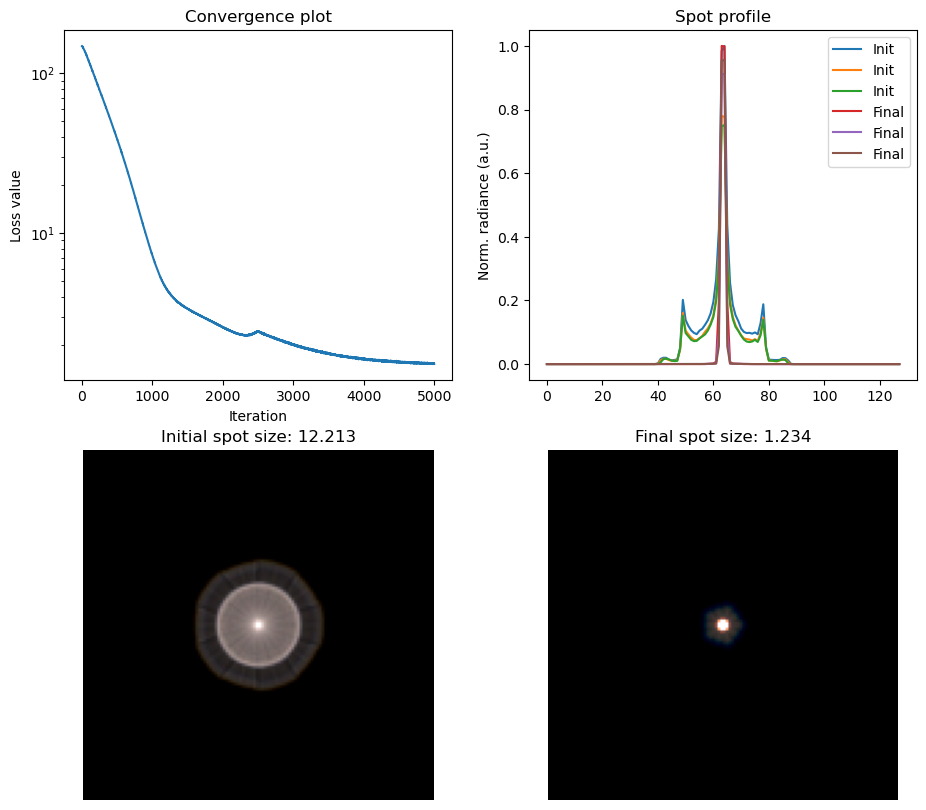

In [21]:
import matplotlib.pyplot as plt

def show_image(ax, img, title):
    ax.imshow(mi.util.convert_to_bitmap(img))
    ax.axis('off')
    ax.set_title(title)

def show_heightmap(fig, ax, values, title):
    im = ax.imshow(values.squeeze(), vmax=1e-4)
    fig.colorbar(im, ax=ax)
    ax.axis('off')
    ax.set_title(title)

def plot_progress(image_init, image, loss_values, average_spot=True):
    fig, ax = plt.subplots(2, 2, figsize=(11, 10))
    ax = ax.ravel()
    ax[0].semilogy(loss_values)
    ax[0].set_xlabel('Iteration'); ax[0].set_ylabel('Loss value'); ax[0].set_title('Convergence plot')

    spot_init  = image_init.numpy()[config['render_resolution'][0] // 2]
    spot_final = image.numpy()[config['render_resolution'][0] // 2]

    if average_spot:
        spot_init = np.mean(image_init, axis=1)
        spot_final = np.mean(image, axis=1)
    ax[1].plot(spot_init / np.max(spot_init), label="Init")
    ax[1].plot(spot_final / np.max(spot_final), label="Final")
    ax[1].set_title('Spot profile')
    ax[1].set_ylabel("Norm. radiance (a.u.)")
    ax[1].legend(loc='upper right')

    show_image(ax[2], image_init, f'Initial spot size: {np.sqrt(rms_loss(image_init).numpy().item()):.3f}')
    show_image(ax[3], image / (100 * np.mean(image)),      f'Final spot size: {np.sqrt(rms_loss(image).numpy().item()):.3f}')
    return fig

_ = plot_progress(image_init * 0.01, image * 0.01, loss_values, False)

In [22]:
for element in lens_system.elements:
    print(element.surface.params)
lens_system.meshplot_geometry()

{'c': [-0.17739839851856232], 'K': 0.0, 'z0': 4.7}
{'c': [0.6790199279785156], 'K': 0.0, 'z0': 5.0}
{'c': [0.3298546373844147], 'K': 0.0, 'z0': 5.1}


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


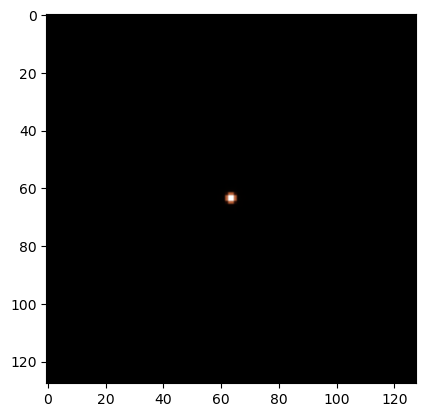

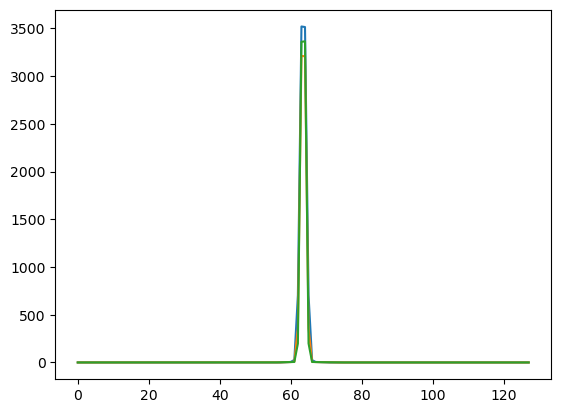

In [23]:
image_final = image.numpy()
spot_final = image_final[config['render_resolution'][0] // 2]
plt.imshow(image_final * 0.001)
plt.figure()
plt.plot(spot_final)

In [24]:
print(dr.sqrt(rms_loss(image_init)))
print(dr.sqrt(rms_loss(image)))
# plt.imshow(image)

[12.212790489196777]
[1.2336790561676025]
